In [248]:
import networkx as nx
import numpy as np
import torch_geometric
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 

import matplotlib.pyplot as plt

from torch_geometric.data import Dataset, Data
from torch_geometric.loader.dataloader import DataLoader

from GraphDataset import RandomGraphDataset
from GraphToSequence import graphToSequence, sequenceToGraph

from SimpleTransformer import SimpleTransformer

In [249]:
data_folder_training = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_training"
data_folder_test = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_test"


dataset_training = RandomGraphDataset(data_folder_training, nodes=100, edges=20, data_count=1000)
dataset_test = RandomGraphDataset(data_folder_test, nodes=100,  edges=20, data_count=50)

In [250]:
def char_to_index_dict(strings):
    # 1. Create a vocabulary (mapping char -> index)
    all_chars = sorted(list(set("".join(strings))))  # Unique characters
    char_to_index = {char: index for index, char in enumerate(all_chars, 1)}
    char_to_index['STOP'] = 0 
    return char_to_index

In [251]:
def string_list_to_char_tensor(strings, char_to_index, max_len=-1):
    """Converts a list of strings to a character-level encoded tensor.

    Args:
        strings: A list of strings.

    Returns:
        A LongTensor where each row represents a string, and each element
        in the row is the character index.  Returns None if the input
        list is empty.
    """

    if not strings:
        return None
        

    # 2. Determine maximum string length for padding
    if max_len <= 0:
        max_len = max(len(s) for s in strings)

    # 3. Create the tensor
    tensor = torch.zeros(len(strings), max_len, dtype=torch.long)  # Initialize with padding (0)

    # 4. Populate the tensor
    for i, string in enumerate(strings):
        for j, char in enumerate(string):
            tensor[i, j] = char_to_index[char]

    return tensor

In [252]:
def generate_data(num_samples, sequence, char_to_index, sequence_length):
    idx = np.random.randint(0, len(seq)-3, (num_samples,))
    vals = [sequence[idx[i]:idx[i]+sequence_length+1] for i in idx]
    inputs = string_list_to_char_tensor(vals, char_to_index)
    return inputs[:,:-1], inputs[:,1:]

In [253]:
def char_tensor_to_string_list(char_tensor, char_to_index):
    index_to_char = {index: char for char, index in char_to_index.items()}
    strings = []
    for row in char_tensor:
        strings.append("".join([index_to_char[idx.item()] for idx in row if idx != 0])) #Ignore padding (0)
    
    return strings

In [254]:
# optional: plot the training loss and save to a file
plot_training_loss = True

# Check for GPU availability
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Hyperparameters
seq = "4.8.;13.11.(12.6.(7.9.10.5.*6.3.1.2.*11.))"
embed_size = 512
sequence_length = 10
vocab_size = 16  # Simple vocab size for demonstration
num_samples = 100
batch_size = 32
learning_rate = 0.001
epochs = 50

In [255]:
# Model, loss, and optimizer
model = SimpleTransformer(embed_size, sequence_length, vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss()

# Optionally introduce weight decay
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Generating data
char_to_index = char_to_index_dict([seq])
print(char_to_index)
inputs, targets = generate_data(num_samples, seq, char_to_index, sequence_length)

# Create a TensorDataset to hold the inputs and targets
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

{'(': 1, ')': 2, '*': 3, '.': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, ';': 15, 'STOP': 0}


In [256]:
# inputs

In [257]:
# targets

In [258]:
losses_per_epoch = []

# Optionally introduce gradient clipping
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for input_batch, target_batch in dataloader:
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        optimizer.zero_grad()
        output = model(input_batch)
        loss = loss_fn(output.view(-1, vocab_size), target_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    losses_per_epoch.append(loss)

Epoch 1, Loss: 2.937374
Epoch 2, Loss: 1.473996
Epoch 3, Loss: 1.211999
Epoch 4, Loss: 1.056850
Epoch 5, Loss: 1.005773
Epoch 6, Loss: 0.936256
Epoch 7, Loss: 0.924060
Epoch 8, Loss: 0.827772
Epoch 9, Loss: 0.786736
Epoch 10, Loss: 0.726652
Epoch 11, Loss: 0.691254
Epoch 12, Loss: 0.615961
Epoch 13, Loss: 0.603275
Epoch 14, Loss: 0.503116
Epoch 15, Loss: 0.502501
Epoch 16, Loss: 0.526860
Epoch 17, Loss: 0.508938
Epoch 18, Loss: 0.470088
Epoch 19, Loss: 0.443431
Epoch 20, Loss: 0.425098
Epoch 21, Loss: 0.390861
Epoch 22, Loss: 0.308264
Epoch 23, Loss: 0.278757
Epoch 24, Loss: 0.269062
Epoch 25, Loss: 0.252757
Epoch 26, Loss: 0.217553
Epoch 27, Loss: 0.204230
Epoch 28, Loss: 0.203004
Epoch 29, Loss: 0.161949
Epoch 30, Loss: 0.200565
Epoch 31, Loss: 0.181555
Epoch 32, Loss: 0.203961
Epoch 33, Loss: 0.180310
Epoch 34, Loss: 0.128059
Epoch 35, Loss: 0.149431
Epoch 36, Loss: 0.133900
Epoch 37, Loss: 0.122702
Epoch 38, Loss: 0.095406
Epoch 39, Loss: 0.122460
Epoch 40, Loss: 0.158341
Epoch 41,

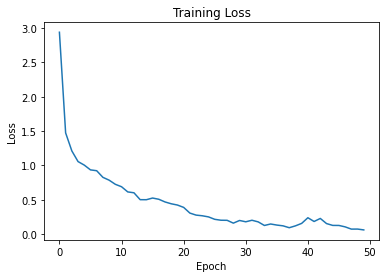

In [259]:
if plot_training_loss:
    plt.plot(losses_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")

In [260]:
for i in range(len(seq) - 6):
    # Example sequence
    sample_sequence = string_list_to_char_tensor([seq[i:i+sequence_length]], char_to_index, sequence_length)
    sample_tensor = (
        torch.tensor(sample_sequence.numpy()[0], dtype=torch.long).unsqueeze(0).to(device)
    )  # Add batch dimension and send to device

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        predictions = model(sample_tensor)
        predicted_index = predictions.argmax(
            -1
        )  # Get the index of the max log-probability for the last position

    predicted_number = predicted_index[0, -1].item()  # Convert to Python number
    print(f"Input Sequence: {seq[i:i+sequence_length+1]}")

    res = torch.roll(sample_tensor, -1, dims=1)
    res[0, -1] = predicted_number 

    print(f"Predicted Sequence: {char_tensor_to_string_list(res, char_to_index)[0]}")
    print(f"Correct: {char_tensor_to_string_list(res, char_to_index)[0] == seq[i+1:i+sequence_length+1]}")





Input Sequence: 4.8.;13.11.
Predicted Sequence: .8.;13.11.
Correct: True
Input Sequence: .8.;13.11.(
Predicted Sequence: 8.;13.11.(
Correct: True
Input Sequence: 8.;13.11.(1
Predicted Sequence: .;13.11.(1
Correct: True
Input Sequence: .;13.11.(12
Predicted Sequence: ;13.11.(1.
Correct: False
Input Sequence: ;13.11.(12.
Predicted Sequence: 13.11.(12.
Correct: True
Input Sequence: 13.11.(12.6
Predicted Sequence: 3.11.(12.6
Correct: True
Input Sequence: 3.11.(12.6.
Predicted Sequence: .11.(12.6.
Correct: True
Input Sequence: .11.(12.6.(
Predicted Sequence: 11.(12.6.2
Correct: False
Input Sequence: 11.(12.6.(7
Predicted Sequence: 1.(12.6.(7
Correct: True
Input Sequence: 1.(12.6.(7.
Predicted Sequence: .(12.6.(7.
Correct: True
Input Sequence: .(12.6.(7.9
Predicted Sequence: (12.6.(7.9
Correct: True
Input Sequence: (12.6.(7.9.
Predicted Sequence: 12.6.(7.9.
Correct: True
Input Sequence: 12.6.(7.9.1
Predicted Sequence: 2.6.(7.9.1
Correct: True
Input Sequence: 2.6.(7.9.10
Predicted Sequence: .